# Pipeline Model

Import the required packages

In [61]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os

import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
import tensorflow as tf

import datetime
pd.set_option('display.max_rows', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters
Set pipeline parameters that are relevant throughout the script. 

In [48]:
CSV_INPUT = 'dev/df_final_2.csv'
CONV_INPUT_LENGTH = 288
TRAIN_TEST_SPLIT = 0.8
ADAM_LEARNING_RATE = 0.001
ACTIVATION_FUNCTION = 'relu'
NUM_EPOCHS = 10
MINIBATCH_SIZE = 64

## Load data

In [49]:
# Persist an unaltered deep copy of the data for faster iterations. 
df_raw = pd.read_csv(os.path.join('..', CSV_INPUT), )
df = df_raw.copy(deep=True)

## Train-Test split

In [50]:
# Sort DF for time-based train-test split
df = df.sort_values('LocalDtTm')
train_length = int(TRAIN_TEST_SPLIT*df.shape[0])
df_train = df.iloc[:train_length,:]
df_test = df.iloc[train_length:,:]
assert df_test.shape[0] + df_train.shape[0] == df.shape[0], 'Train-Test shapes don not add up.'

X_train = df_train.drop(columns=['LocalDtTm', 'CGM'])
Y_train = df_train[['CGM']]

X_test = df_test.drop(columns=['LocalDtTm', 'CGM'])
Y_test = df_test[['CGM']]

## Model

In [51]:
# Future TODO: Create custom loss. 
class GlucoseLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred):
        pass


In [52]:
# Custom metric: Share of correctly recognized hyper glucose states. 
def hyper_metric(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1,))
    y_pred = tf.reshape(y_pred, shape=(-1,))
    preds_while_hyper = tf.boolean_mask(y_pred, mask=tf.greater(y_true, 100.0))
    return tf.reduce_mean(tf.cast(tf.greater(preds_while_hyper, 100.0), tf.float32))

# Custom metric: Share of correctly recognized hypo glucose states. 
def hypo_metric(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1,))
    y_pred = tf.reshape(y_pred, shape=(-1,))
    preds_while_hyper = tf.boolean_mask(y_pred, mask=tf.less(y_true, 70.0))
    return tf.reduce_mean(tf.cast(tf.less(preds_while_hyper, 70.0), tf.float32))


In [53]:
# In order to avoid code duplication, create a custom "ConvLayer" that will be created four times. 
# See Figure 1 in milestone report. 
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ConvLayer, self).__init__()
        self.conv1 = tfl.Conv1D(filters = 3, kernel_size = 5, strides = 1, padding = 'valid')
        self.pool1 = tfl.MaxPool1D(pool_size = 2, strides = 2, padding = 'valid')
        self.conv2 = tfl.Conv1D(filters = 6, kernel_size = 5, strides = 1, padding = 'valid')
        self.pool2 = tfl.MaxPool1D(pool_size = 6, strides = 4, padding = 'valid')
        self.flatten = tfl.Flatten()


    def build(self, input_shape):
        pass

    def call(self, input):
            
        assert input.shape[1] == CONV_INPUT_LENGTH
        # 1st CONV
        conv1_out = self.conv1(input)
        # Max Pool
        pool1_out = self.pool1(conv1_out)
        # 2nd CONV
        conv2_out = self.conv2(pool1_out)
        # Max Pool
        pool2_out = self.pool2(conv2_out)
        # Now flatten the Matrix into a 1D vector (shape 1x204)
        flatten_out = self.flatten(pool2_out)

        return flatten_out

In [54]:
def get_model():
    
    
    # define the input with specified shape
    # Don't specify batch-size to make pipeline more robust. 
    input = tf.keras.Input(shape =(CONV_INPUT_LENGTH*4,1), batch_size=None)
    # Calculate batchsize of current run. 
    batch_size = tf.shape(input)[0]
    
    # Slice the data into four equally sized 1D-chunks for CNN. 
    diabetes_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*0,0], size=[batch_size,CONV_INPUT_LENGTH,1], name='diabetes_input')
    meal_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*1,0], size=[batch_size,CONV_INPUT_LENGTH,1])
    smbg_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*2,0], size=[batch_size,CONV_INPUT_LENGTH,1])
    excercise_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*3,0], size=[batch_size,CONV_INPUT_LENGTH,1])

    # Create the four custom conv-layers
    diabetes_conv = ConvLayer()(diabetes_input)
    meal_conv = ConvLayer()(meal_input)
    smbg_conv = ConvLayer()(smbg_input)
    excercise_conv = ConvLayer()(excercise_input)

    # Concat the result of conv-layers
    post_conv = tf.concat([diabetes_conv, meal_conv, smbg_conv, excercise_conv], axis=1, name='post_conv')
    
    # Sanity check: Make sure that the shapes are as expected. 
    assert post_conv.shape[1] == 204*4, 'Shape mismatch after conv layers'

    # Now fully connect layers
    # Use multiples of two as recommended in class.
    FC1 = tfl.Dense(units = 512, activation = ACTIVATION_FUNCTION)(post_conv)
    FC2 = tfl.Dense(units = 256, activation = ACTIVATION_FUNCTION)(FC1)
    FC3 = tfl.Dense(units = 128, activation = ACTIVATION_FUNCTION)(FC2)
    FC4 = tfl.Dense(units = 64, activation = ACTIVATION_FUNCTION)(FC3)
    # The output does NOT have an activation (regression task)
    output = tfl.Dense(units = 1, activation = None)(FC4)
    
    model = tf.keras.Model(inputs = input, outputs = output)
    return model

Now try the function:

In [55]:
# Create model
conv_model = get_model()
# Create optimizer (Adam with specified learning rate - use default parameters otherwise. )
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE)
# Compile model - use mse for now. 
conv_model.compile(optimizer=adam_optimizer,
                  loss='mse', 
                  metrics=['mse', hypo_metric, hyper_metric])
conv_model.summary()
    

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1152, 1)]    0           []                               
                                                                                                  
 tf.compat.v1.shape_2 (TFOpLamb  (3,)                0           ['input_3[0][0]']                
 da)                                                                                              
                                                                                                  
 tf.__operators__.getitem_2 (Sl  ()                  0           ['tf.compat.v1.shape_2[0][0]']   
 icingOpLambda)                                                                                   
                                                                                            

In [56]:
# Create train and test datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(MINIBATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(MINIBATCH_SIZE)
# Let's run this!
history = conv_model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
710/710 [==============================] - 10s 13ms/step - loss: 3557.6211 - mse: 3557.6211 - hypo_metric: nan - hyper_metric: 0.8211 - val_loss: 2069.6062 - val_mse: 2069.6062 - val_hypo_metric: nan - val_hyper_metric: 0.9891
Epoch 2/10
710/710 [==============================] - 11s 15ms/step - loss: 2233.6226 - mse: 2233.6226 - hypo_metric: nan - hyper_metric: 0.9434 - val_loss: 1631.0105 - val_mse: 1631.0105 - val_hypo_metric: nan - val_hyper_metric: 0.9991
Epoch 3/10
710/710 [==============================] - 10s 15ms/step - loss: 1851.5881 - mse: 1851.5881 - hypo_metric: nan - hyper_metric: 0.9729 - val_loss: 1486.4620 - val_mse: 1486.4620 - val_hypo_metric: nan - val_hyper_metric: 0.9992
Epoch 4/10
710/710 [==============================] - 10s 14ms/step - loss: 1682.5640 - mse: 1682.5640 - hypo_metric: nan - hyper_metric: 0.9796 - val_loss: 1412.0811 - val_mse: 1412.0811 - val_hypo_metric: nan - val_hyper_metric: 0.9995
Epoch 5/10
710/710 [============================

In [57]:
# Create predictions
preds_train = conv_model.predict(X_train)
preds_test = conv_model.predict(X_test)


355/355 [==============================] - 1s 3ms/step


## Plot the predictions against the actual values

(20.9, 817.889225769043, 3.6649253845214815, 800.6541511535645)

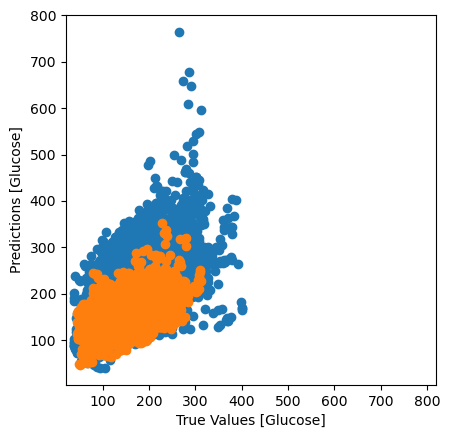

In [62]:
# Plot the predictions against the actual values
plt.scatter(Y_train, preds_train)
plt.xlabel('True Values [Glucose]')
plt.ylabel('Predictions [Glucose]')
plt.axis('equal')
plt.axis('square')


#plot test predictions against actual test values
plt.scatter(Y_test, preds_test)
plt.xlabel('True Values [Glucose]')
plt.ylabel('Predictions [Glucose]')
plt.axis('equal')
plt.axis('square')



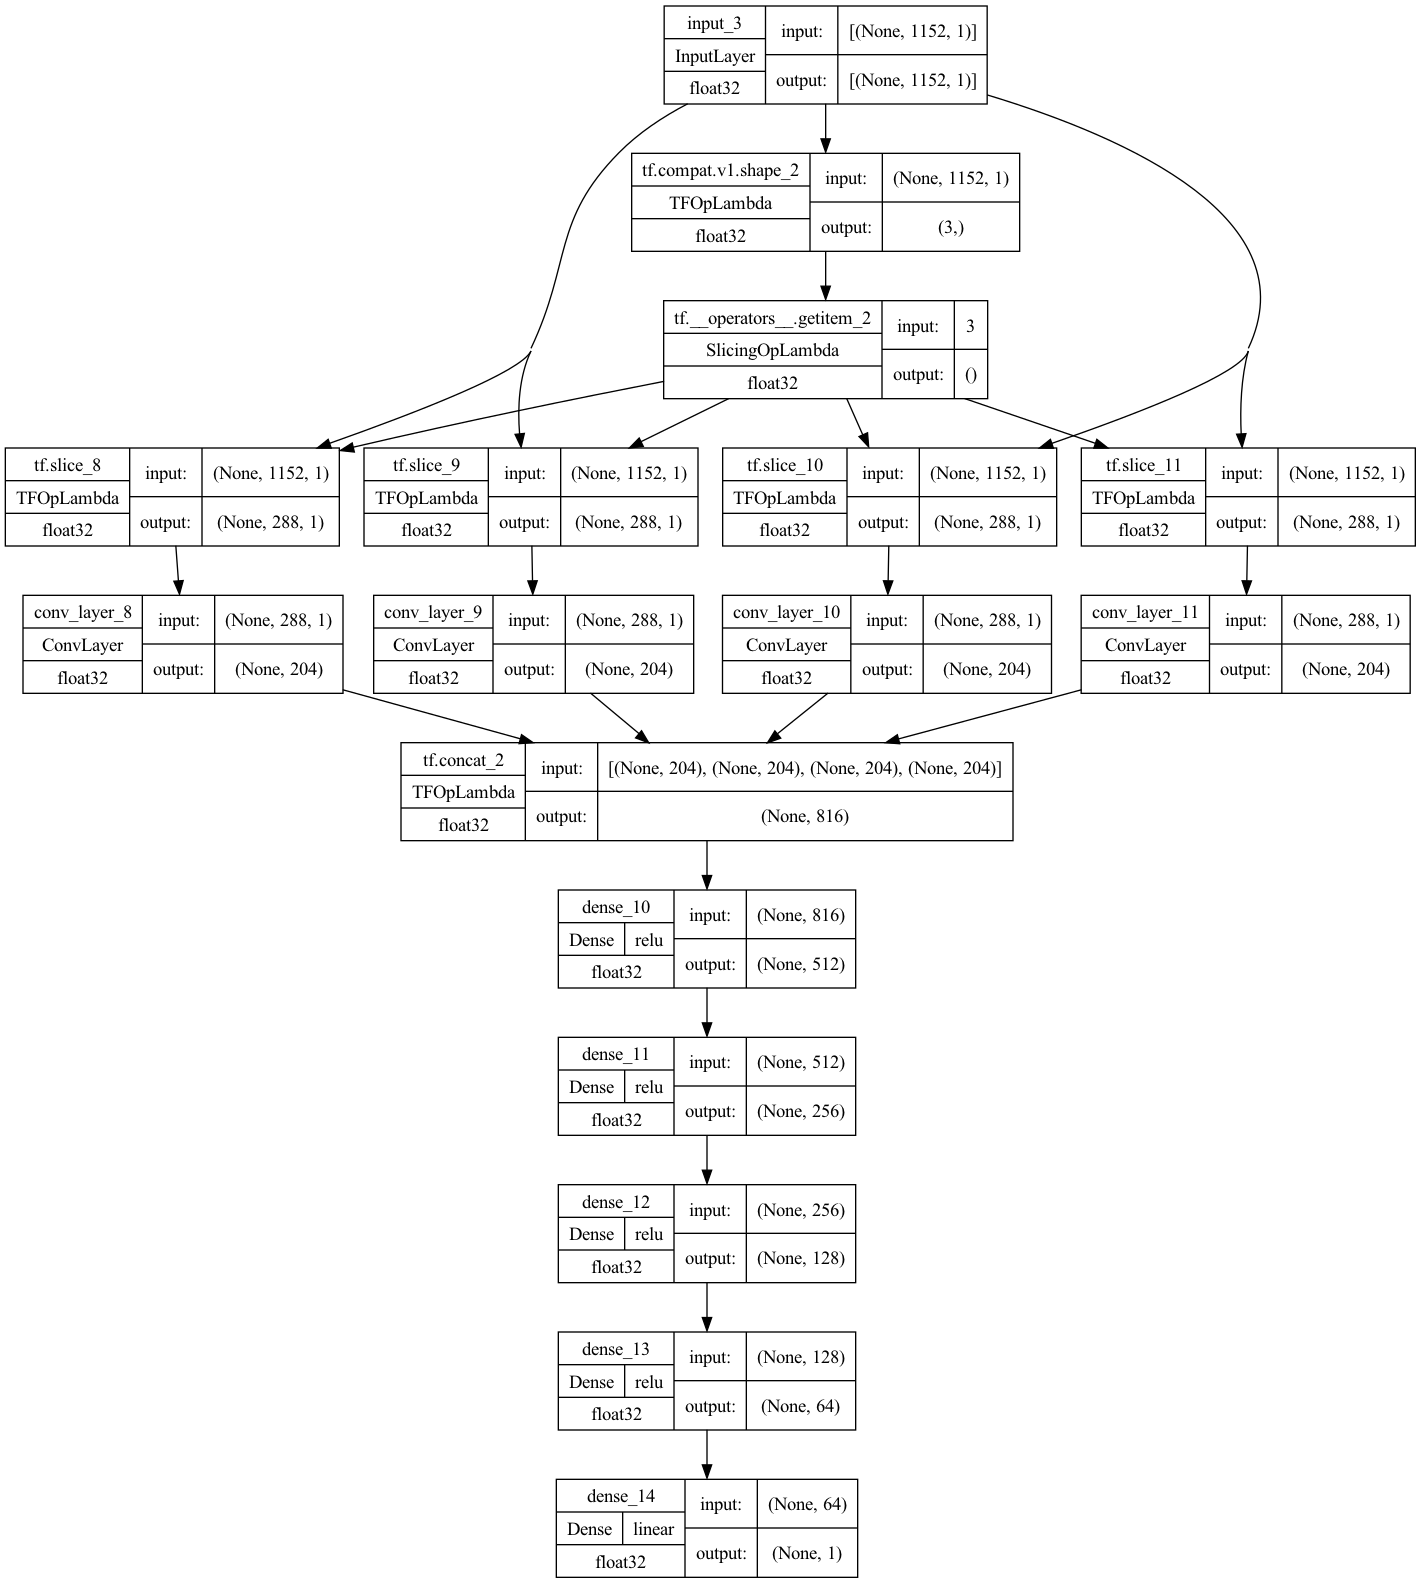

In [63]:
# Create more detailed plot (potentailly in Appendix?)
tf.keras.utils.plot_model(conv_model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)
